### Import modules

In [1]:
import math
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

plt.style.use("ggplot")
%matplotlib inline

Using TensorFlow backend.


### Load data

In [2]:
# each sample lasts 30 seconds (sampling rate: 200 Hz)
eeg_data = loadmat("./eeg_data.mat")
x = eeg_data['X_train']

# labels
sleep_stages = eeg_data['y_train']
print(np.unique(sleep_stages))

# targets
le = LabelEncoder()
labels = le.fit_transform(sleep_stages)
y = to_categorical(labels)

['N1' 'N2' 'N3' 'R ' 'W ']


In [38]:
# shape
print(x.shape)

(10178, 6000)


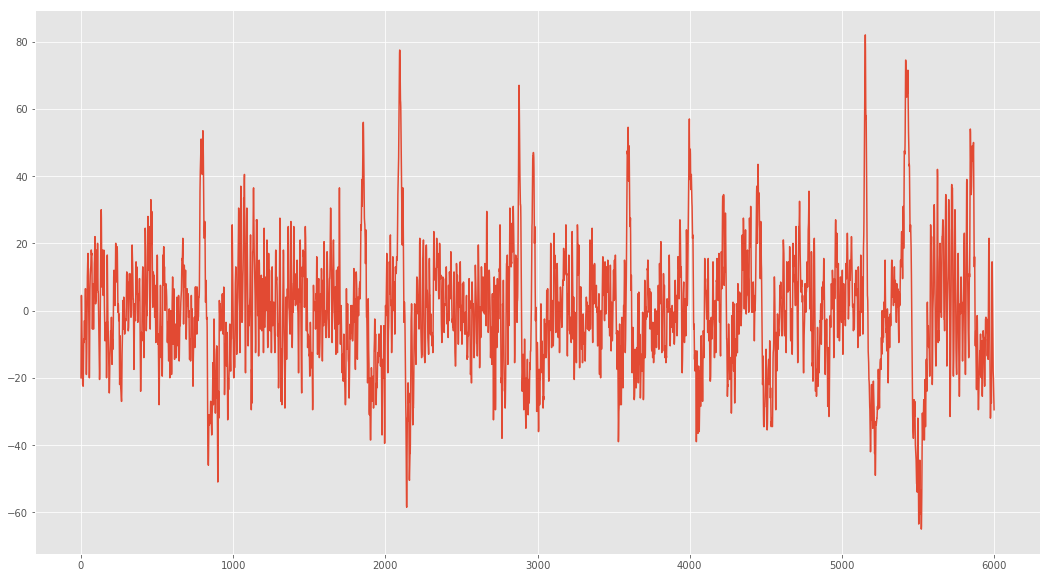

In [39]:
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(x[0])

## Sub-sampling eeg signal

In [40]:
# sub-sampling
x_sub = x[:, ::3]
print(x_sub.shape)

(10178, 2000)


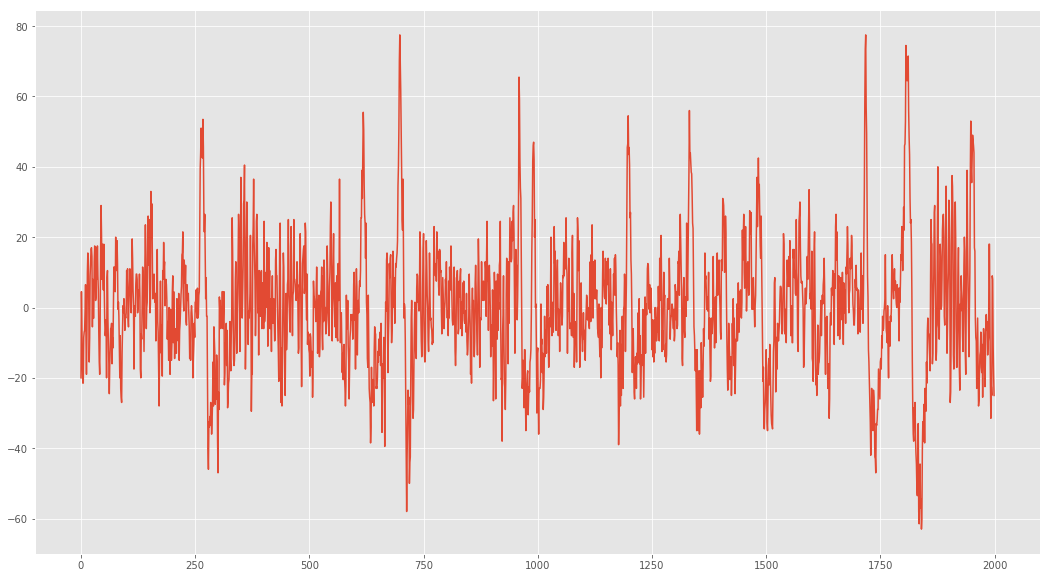

In [6]:
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(x_sub[0])

## CNN architecture

In [70]:
# parameters
win_sec = 3
overlap = 1
num_filters = 100
learning_rate = 1e-2

# pretty print
n, sample_size = x_sub.shape
freq = sample_size / 30
num_classes = np.shape(y)[1]
win_size = int(win_sec * freq)
overlap_size = int(overlap * freq)
filter_size = win_size
stride = overlap_size
print("%d samples" % n)
print("sampling rate: %.2f Hz" % freq)
print("sample size: %d" % sample_size)
print()
print("window of %.2f seconds: filter size of %d samples" % (win_sec, win_size))
print("overlapping windows of %.2f seconds: stride of %d samples" % (overlap, overlap_size))
print()
print("number of classes: %d" % num_classes)
print("number of filter size: %d" % num_filters)

10178 samples
sampling rate: 66.67 Hz
sample size: 2000

window of 3.00 seconds: filter size of 200 samples
overlapping windows of 1.00 seconds: stride of 66 samples

number of classes: 5
number of filter size: 100


In [96]:
# helper functions 
def apply_conv(filter_size, stride, num_filters):
    filter_shape = [filter_size, 1, 1, num_filters]
    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
    b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name='b')
    conv = tf.nn.conv2d(x_expanded,
                        W, 
                        strides=[1, stride, 1, 1],
                        padding='VALID',
                        name='conv')
    return conv

def apply_max_pool(h):
    shape_ = h.get_shape().as_list()
    h_pool = tf.nn.max_pool(h,
                            ksize=[1, shape_[1], 1, 1],
                            strides=[1, 1, 1, 1], 
                            padding='VALID',
                            name='pool')
    h_flat = tf.reshape(h_pool, [-1, num_filters])
    return h_flat

In [97]:
%%time

# placeholders
x_input = tf.placeholder(tf.float32, shape=[None, sample_size], name='x_input')
y_input = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_input')
dropout = tf.placeholder(tf.float32, name="dropout_keep_prob")

with tf.device("/cpu:0"):
    
    # resize time series
    with tf.name_scope("expand"):
        x_expanded = tf.expand_dims(tf.expand_dims(x_input, -1), -1)
    
    with tf.name_scope("convolution"):
        # convolution
        conv = apply_conv(filter_size, stride, num_filters)
        # non-linearity
        h = tf.nn.tanh(tf.nn.bias_add(conv, b), name='tanh')
        # k-max
        h_flat = apply_max_pool(h)
        
    # dropout
    with tf.name_scope("dropout"):
        h_o = tf.nn.dropout(h_flat, dropout)

    # output
    with tf.name_scope("output"):
        W_o = tf.Variable(
            tf.truncated_normal(
                [num_filters, num_classes], stddev=0.1 ), 
                name='W_o'
        )
        b_o = tf.Variable(tf.constant(0.1, shape=[num_classes]), name='b_o')
        output = tf.nn.xw_plus_b(h_o, W_o, b_o, name='scores')
        preds = tf.nn.relu(output, name='last_relu')
        
    # cross-entropy loss
    with tf.name_scope("loss"):
        losses = tf.nn.softmax_cross_entropy_with_logits(
            logits=preds,
            labels=y_input,
            name='losses'
        )
        loss = tf.reduce_mean(losses, name='loss')

    # accuracy
    with tf.name_scope("accuracy"):
        correct_predictions = tf.equal(tf.argmax(preds, axis=1), tf.argmax(y_input, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')

    # optimization
    with tf.name_scope("optimization"):
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss) 
        
    init = tf.global_variables_initializer()

Wall time: 312 ms


In [102]:
%%time
with tf.Session() as sess:
    sess.run(init)
    D = {x_input: x_sub, y_input: y, dropout: 1}
    out = sess.run(accuracy, feed_dict=D)
    
if type(out) == np.float32:
    print(out)
else:
    print(out.shape)

0.200629
Wall time: 2.43 s


In [103]:
batch_size = 32
num_epochs = 2 
p = 2
seed = 0
x_train, x_test, y_train, y_test = train_test_split(x_sub, y, train_size=0.75, random_state=seed)

In [104]:
%%time

with tf.Session() as sess:
    # init
    sess.run(init)
    acc_train = sess.run(accuracy, feed_dict={x_input: x_train, y_input: y_train, dropout: 1})
    acc_test = sess.run(accuracy, feed_dict={x_input: x_test, y_input: y_test, dropout: 1})
    print("init.: _ train acc: %0.2f test acc: %0.2f" % (acc_train, acc_test))
    
    # training
    losses = []
    for e in range(num_epochs):
        for i in range(x_train.shape[0] // batch_size):
            idx = i * batch_size
            idxn = min(x_train.shape[0] - 1, (i+1) * batch_size)
            batch_xs = x_train[idx: idxn]
            batch_xy = y_train[idx: idxn]
            feed_train = {x_input: batch_xs, y_input: batch_xy, dropout: p}
            __, l = sess.run([train_op, loss], feed_dict=feed_train)
            losses.append(l)
            
        acc_train = sess.run(accuracy, feed_dict={x_input: x_train, y_input: y_train, dropout: p})
        acc_test = sess.run(accuracy, feed_dict={x_input: x_test, y_input: y_test, dropout: 1})
        print("epoch: %d train acc: %0.2f test acc: %0.2f" % (e, acc_train, acc_test))
        
    file_writer = tf.summary.FileWriter('./tensorflow_summaries', sess.graph)

init.: _ train acc: 0.17 test acc: 0.17
epoch: 0 train acc: 0.41 test acc: 0.42
epoch: 1 train acc: 0.41 test acc: 0.42
Wall time: 11.1 s


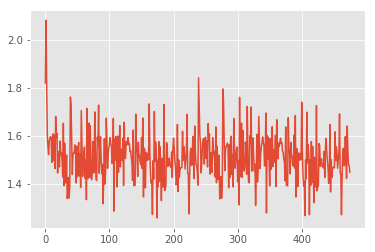

In [105]:
plt.plot(losses)